# Uncertainty estimation with deep learning for discharge prediction


This is a project for the course CEGM2003 Data Science and Artificial Intelligence for Engineers,
created by the members of the HBV Group: 
- Dwiva Anbiya Taruna (5849578)
- Konstantina Bourazani (5728347)
- Hang Long (5743702)
- Thomas Poort (4715500)

In [17]:
import pickle
import numpy as np
from pathlib import Path
import datetime

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run
from neuralhydrology.utils.nh_results_ensemble import create_results_ensemble
from neuralhydrology.nh_run_scheduler import schedule_runs
from neuralhydrology.evaluation.plots import percentile_plot, regression_plot, uncertainty_plot
from neuralhydrology.datasetzoo.camelsus import CamelsUS, load_camels_us_attributes, load_camels_us_discharge, load_camels_us_forcings

## Introduction


Rainfall runoff modeling is extremely important for hydrological science as it plays an huge role in understanding and managing water resources. The water cycle, containing factors such as precipitation and evaporation, contains many interactions between the atmosphere, the land surface and the river system. Understanding each of these factors and how they impact the river systems is extremely important. Especially in current times of climate change and urbanization that continues to reshape landscapes, there is a need for accurate and reliable rainfall runoff models. In the past years it has become increasingly apparent that the climate has been changing and that river systems have been impacted greatly in the forms of droughts or floods.


<center><figure>
  <img src="Images/droughts_river_france.jpg" width=400/>
  <img src="Images/floods_river_germany.jpg" width=400/>
</figure></center>

Therefore, predicting the runoff in river systems is crucial for a multitude of applications, such as water resource management, flood risk assessment, urban planning or early warning systems. Hydrological prediction is important in effective water resource management, playing a pivotal role in addressing the challenges posed by climate variability and change. 

<center><figure>
  <img src="Images/rainfall_runoff.jpg" width=600/>
<figcaption>Rainfall-Runoff
</figure></center>

However, until now rainfall predictions have been computed deterministically without providing any information about the uncertainty that plays a significant role in these predictions. It is crucial to quantify uncertainties in rainfall-runoff predictions for multiple reasons, as it provides stakeholders a better understanding of the the possible outcoems that could occur. Therefore it is crucial for decision-making in many sectors, for example water resource management, agriculture and disaster risk reduction. 


For that reason there is a need to estimate the uncertainty by using probabilistic predictions instead of deterministic ones. The main goal of this project is to investigate different methods for uncertainty estimation in discharge prediction using probabilistic predictions.


## Objectives

The project has four objectives:

•	**Hands-on Discharge prediction:** 
    
    - Gain practical experience in discharge prediction using machine learning techniques.

•	**Uncertainty Estimation for Discharge Prediction:**

    - Use a LSTM model combined with Monte Carlo Dropout to make probabilistic predictions.

•	**Evaluation Metrics Exploration:** 

    - Probabilistic: Explore suitable metrics (PICP, PINAW) for evaluating the performance of various uncertainty estimation methods.
    - Deterministic: Using the ensemble of the MCD output, compare to the LSTM predictions.

•	**Transfer Learning:** 

    - Assess whether the obtained model can be used for Transfer Learning for different basins.




For that purpose the following workplan/flowchart was created:

<center><figure>
  <img src="Images/CEGM2003_new.png" width=600/>
<figcaption>Workplan
</figure></center>

## Data

For this project data was used from the CAMELS US dataset (Catchment Attributes and Meteorology for Large-sample Studies). This dataset contains of two main aspects; the hydrometeorological time series of each basin and the catchment attributes. 


The hydrometeorological time series contains all the meteorological data that is used as input as well as time series of streamflow observations for each basin. The catchment attributes dataset contains information about a wide range of attributes that are able to influence catchment behaviour such as topographic characteristics (slope, elevation), soil characteristics (soil depth, porosity), geological characteristics etc.

 
From this dataset that contains in total 671 catchments in the United States, one specific hydrological unit (HUC) was selected to use as input data for our model. The selected region was HUC 17 which is the North-Western area of the United States including for instance the states of Washington and Oregon.


<center><figure>
  <img src="Images/CAMELS_US_HUC.png" width=600/>
<figcaption>CAMELS US Data
</figure></center>

In [18]:
# Data path
data_dir = Path("../data/CAMELS_US")

# Load the attributes
attributes_df = load_camels_us_attributes(data_dir)

# Filter for HUC 17
huc_17_df = attributes_df[attributes_df['huc'] == '17']

# Display the first few rows of the filtered DataFrame
huc_17_df.describe()

,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,glim_1st_class_frac,...,area_gages2,area_geospa_fabric,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,root_depth_50,root_depth_99
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,...,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,85.000000,85.000000
mean,5.218636,2.389709,-0.724606,0.329195,0.590950,13.787912,1.494834,207.033516,5.345078,0.703099,...,658.088022,664.112527,0.910460,3.422506,2.162443,0.774458,0.213541,0.851446,0.172369,1.824864
std,2.033162,0.391388,0.171490,0.232562,0.403171,3.536416,0.148753,26.763967,0.826802,0.201268,...,1607.415592,1606.887588,0.192117,1.075691,0.611926,0.131486,0.064077,0.160766,0.023162,0.159680
min,1.370110,1.899096,-1.015946,0.010676,0.220284,7.900000,1.245989,169.900000,4.141998,0.320226,...,8.060000,8.070000,0.004500,0.758705,0.565572,0.331168,0.077388,0.459891,0.120000,1.500000
25%,3.368297,2.104638,-0.831889,0.119957,0.307211,11.400000,1.395593,185.150000,4.736098,0.530979,...,74.330000,80.225000,0.912050,2.689582,1.813418,0.714511,0.170486,0.738311,0.169046,1.776767
50%,5.556071,2.245585,-0.768302,0.324496,0.419493,13.000000,1.459716,201.750000,5.105131,0.712490,...,286.850000,292.890000,0.988700,3.683826,2.305981,0.831343,0.210273,0.908508,0.170000,1.800000
75%,6.991329,2.691361,-0.630807,0.524527,0.768379,15.075000,1.574628,223.600000,5.883743,0.897849,...,603.415000,640.795000,1.000000,4.286680,2.601536,0.868282,0.269301,1.000000,0.177319,1.854895
max,8.936886,3.394634,-0.240677,0.777311,2.175574,25.350000,1.853503,279.750000,7.462264,1.000000,...,14268.920000,14270.760000,1.000000,4.980796,3.344280,0.914354,0.347739,1.000000,0.245491,2.366185


In [20]:
# Selected Basin as example
basin_id = '14187000' # WILEY CREEK NEAR FOSTER, OR
area = 134.75*1e6

# Load the discharge data
discharge_series = load_camels_us_discharge(data_dir, basin_id, area)
discharge_series

date
1988-10-01     0.179748
1988-10-02     0.156145
1988-10-03     0.148883
1988-10-04     0.152514
1988-10-05     0.176117
                ...    
2014-12-27     8.224851
2014-12-28    10.367307
2014-12-29     9.041890
2014-12-30     6.844965
2014-12-31     5.410609
Name: QObs, Length: 9588, dtype: float64

In [21]:
forcings_data = load_camels_us_forcings(data_dir, basin_id, forcings='daymet')
print(forcings_data)
forcings_data = load_camels_us_forcings(data_dir, basin_id, forcings='maurer')
print(forcings_data)
forcings_data = load_camels_us_forcings(data_dir, basin_id, forcings='nldas')
print(forcings_data)

(            Year  Mnth  Day  Hr   dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)  \
date                                                                           
1980-01-01  1980     1    1  12  31449.60         12.21       71.02      0.0   
1980-01-02  1980     1    2  12  31449.60          5.02      111.11      0.0   
1980-01-03  1980     1    3  12  31449.60         13.07       92.87      0.0   
1980-01-04  1980     1    4  12  31480.03         10.84       55.56      0.0   
1980-01-05  1980     1    5  12  31795.19         38.25       92.26      0.0   
...          ...   ...  ...  ..       ...           ...         ...      ...   
2014-12-27  2014    12   27  12  31134.43          0.00      120.79      0.0   
2014-12-28  2014    12   28  12  31347.50         20.68       80.97      0.0   
2014-12-29  2014    12   29  12  31449.60         16.33      128.15      0.0   
2014-12-30  2014    12   30  12  31449.60          3.84      161.51      0.0   
2014-12-31  2014    12   31  12  31449.

## Base Model - LSTM

Machine learning has been widely used to produce accurate predictions for optimizing water allocation, flood control, and sustainable environmental practices. Machine learning techniques have emerged as powerful tools in the field of hydrological prediction, offering the potential to enhance accuracy and efficiency. Among these techniques, Long Short-Term Memory (LSTM) networks have gained prominence for their ability to model complex temporal dependencies in data. The application of LSTM models in hydrological prediction involves leveraging their capacity to analyze and learn patterns from historical hydrological data. By understanding the intricate relationships between various meteorological and hydrological variables, LSTMs can generate predictions that contribute to more informed decision-making in water resource management.

<center><figure>
  <img src="Images/LSTM.png" width=600/>
<figcaption>LSTM Model
</figure></center>

### CudaLSTM

CudaLSTM is a specialized variant of the Long Short-Term Memory (LSTM) neural network tailored for high-performance execution on NVIDIA's CUDA platform, which leverages the power of GPUs for parallel processing. This optimization enables the handling of complex, sequential data more efficiently, making it particularly advantageous for time-series analysis in hydrology.

In this project, CudaLSTM is chosen as the base model of LSTM because we are using it with a runpod machine running with NVIDIA RTX4090.

The table below shows what we tried to find the best settings for the basic lstm model shown in Number of LSTM cell states (hidden size)

|                   |    Base Model    |
|:-----------------:|:----------------:|
| Hidden size       | 20, 50, 100, 250 |
| **Batch size**    | 256              |
| **Learning rate** | 0.001            |  |

## Model Head

The model head in this case means the final part of the neural network architecture responsible for generating the specific output format required for a task, which in this case can result in probabilistic modeling. In this project we look at the Monte Carlo Dropout.

### Monte Carlo Dropout (MCD)

Monte Carlo Dropout (MCD) provides a way to estimate the uncertainty of our predictions. In this case dropout is used with a certain dropout rate to randomly inactive certain neural network nodes. This results in a different network structure each time the model is evaluated during training. By repeating this process multiple times an ensemble of many sub-networks is created which all produce predictions. From this ensemble of predictions an uncertainty interval can be created and later on evaluated. 

<center><figure>
  <img src="Images/MCD.png" width=600/>
<figcaption>Monte Carlo Dropout
</figure></center>

The first step was to find a suitable dropout rate to use during the Monte Carlo Dropout process. By using different dropout rates between the range of 0.2-0.5, we tested which dropout rate would be best for our project to use.

## Training

In this part of the training, we used the configurations as specified in the table below:

|                         |        Base LSTM       | Base LSTM + Monte Carlo Dropout |
|:-----------------------:|:----------------------:|:-------------------------------:|
| Training period         | 1 Jan 1980–31 Dec 1999 | 1 Jan 1980–31 Dec 1999          |
| Validation period       | 1 Jan 2000–31 Dec 2004 | 1 Jan 2000–31 Dec 2004          |
| Test period             | 1 Jan 2005–31 Dec 2009 | 1 Jan 2005–31 Dec 2009          |
| Training loss           | MSE                    | MSE                             |
| CAMELS attributes       | Yes                    | Yes                             |
| Input products          | DayMet, Maurer, NLDAS  | DayMet, Maurer, NLDAS           |
| Regularization: dropout | Yes                    | Yes                             |
| Gradient clipping       | Yes                    | Yes                             |
| Regularization: dropout | No                     | Yes                             |
| Batch size              | 256                    | 256                             |
| Learning rate           | 0.001                  | 0.001                           |           |  |           |


## Model Results

In the code above the LSTM model was trained. Now that that is achieved we can test the model performance and show the results. 

In [12]:
# Open model test results from base model
run_dir= Path("Test model results/Base Model/cudalstm_HUC17.p")
with open(run_dir, "rb") as fp:
    results = pickle.load(fp)

# Clipping the results time step until 31-12-2008 and add mean and median var per basin
for key in results.keys():
    # For each dataset in the dictionary
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    # Select data up to and including 31st December 2008
    results[key]['1D']['xr'] = dataset.sel(date=slice(None, '2008-12-31'))

In [13]:
# Open model test results from mcd model
run_dir2= Path("Test model results/MCD Model/HUC_17_dr_04.p")
with open(run_dir2, "rb") as fp:
    results2 = pickle.load(fp)

# Clipping the results time step until 31-12-2008 and add mean and median var per basin
for key in results2.keys():
    # For each dataset in the dictionary
    dataset = results2[key]['1D']['xr']  # Adjust this path based on your dict structure
    dataset['QObs(mm/d)_sim_mean'] = dataset['QObs(mm/d)_sim'].mean(dim='samples')
    dataset['QObs(mm/d)_sim_median'] = dataset['QObs(mm/d)_sim'].median(dim='samples')
    # Select data up to and including 31st December 2008
    results2[key]['1D']['xr'] = dataset.sel(date=slice(None, '2008-12-31'))

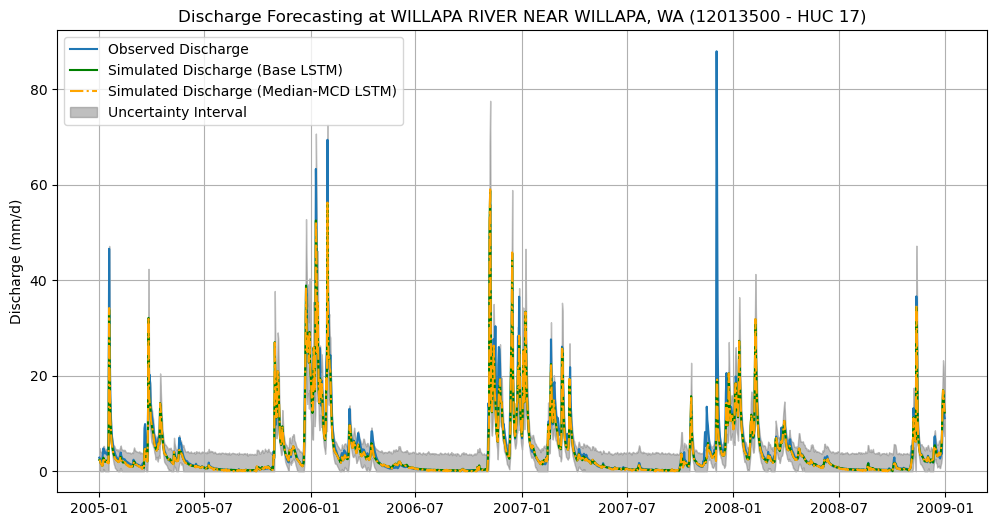

In [14]:
# extract observations and simulations
qobs = results['12013500']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['12013500']['1D']['xr']['QObs(mm/d)_sim']
qsim1a = results2['12013500']['1D']['xr']['QObs(mm/d)_sim_median']
qsim1b = results2['12013500']['1D']['xr']['QObs(mm/d)_sim']
qsim1b = qsim1b.values.swapaxes(0, 2).squeeze()
lb, ub = metrics.calculate_prediction_intervals(qsim1b, percentile=95)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot observed and simulated data
plt.plot(qobs['date'], qobs, label='Observed Discharge')
plt.plot(qsim['date'], qsim, label='Simulated Discharge (Base LSTM)', color='green')
plt.plot(qsim1a['date'], qsim1a, label='Simulated Discharge (Median-MCD LSTM)', linestyle='-.',color='orange')
plt.fill_between(qsim1a['date'], lb, ub, color='gray', alpha=0.5, label='Uncertainty Interval')



# Set labels and title
plt.ylabel("Discharge (mm/d)")
plt.title(f"Discharge Forecasting at WILLAPA RIVER NEAR WILLAPA, WA (12013500 - HUC 17)")

# Add a legend
plt.legend()

# Add grid and set the y-axis limit
plt.grid()

# Show the plot
plt.show()

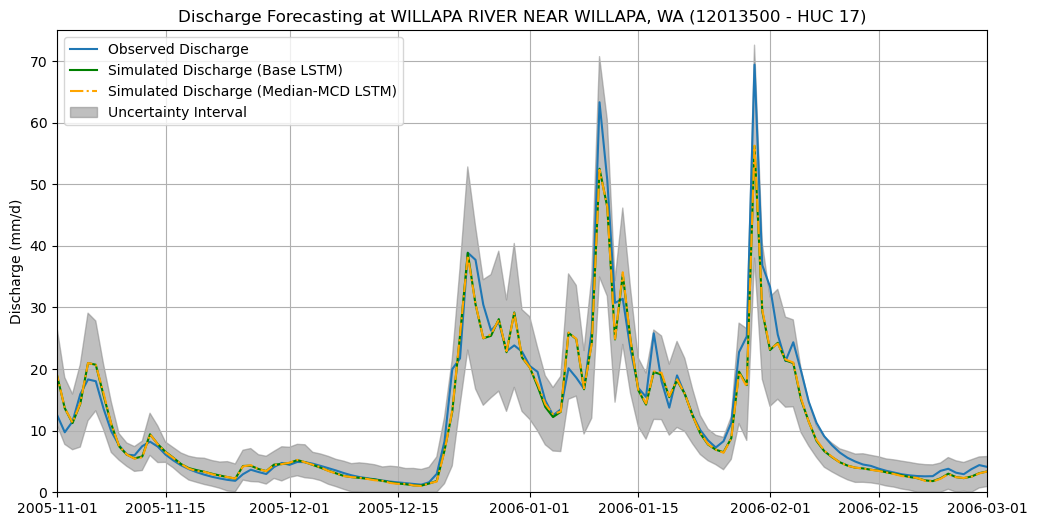

In [15]:
# Create the plot more zoomed to selected peak discharge
plt.figure(figsize=(12, 6))

# Plot observed and simulated data
plt.plot(qobs['date'], qobs, label='Observed Discharge')
plt.plot(qsim['date'], qsim, label='Simulated Discharge (Base LSTM)', color='green')
plt.plot(qsim1a['date'], qsim1a, label='Simulated Discharge (Median-MCD LSTM)', linestyle='-.',color='orange')
plt.fill_between(qsim1a['date'], lb, ub, color='gray', alpha=0.5, label='Uncertainty Interval')

# Set labels and title
plt.ylabel("Discharge (mm/d)")
plt.title(f"Discharge Forecasting at WILLAPA RIVER NEAR WILLAPA, WA (12013500 - HUC 17)")

# Add a legend
plt.legend()

# Add grid and set the y-axis limit
plt.grid()
start_date = datetime.datetime(2005, 11, 1)
end_date = datetime.datetime(2006, 3, 1)

# Set the x-axis limits for the desired date range
plt.xlim(start_date, end_date)

plt.ylim(0, 75)

# Show the plot
plt.show()

## Evaluation Model

The final step is to evaluate the model and the results obtained from the model and Monte Carlo Dropout. We do this in two ways: 

- #### Deterministic:

The Monte Carlo Dropout, shown previously, results in a thousand different prediction time-series for the discharge. It is an option to compare these deterministically to the observations and the used LSTM model without Monte Carlo Dropout. Ensembling is a way to get a deterministic result from multiple predicitons, in our case we have taken the median of all predictions and combined these into one time-series. In the end, this ensemble can be shown combined with the observations and its performance can be compared to the deterministic result we got from just using the LSTM model.

For deterministic evaluation we selected several metrics as follows:

Nash–Sutcliffe efficiency (NSE)
$$\text{NSE} = 1 - \frac{\sum_{t=1}^{T}(Q_m^t - Q_o^t)^2}{\sum_{t=1}^T(Q_o^t - \overline{Q}_o)^2}$$

Mean-Squared error (MSE)
$$\text{MSE} = \frac{1}{T}\sum_{t=1}^T (\widehat{y}_t - y_t)^2$$

Root Mean-Squared error (RMSE)
$$\text{RMSE} = \sqrt{\frac{1}{T}\sum_{t=1}^T (\widehat{y}_t - y_t)^2}$$

Kling-Gupta Efficiency (KGE) Term
$$\text{KGE} = 1 - \sqrt{[ s_r (r - 1)]^2 + [s_\alpha ( \alpha - 1)]^2 +
    [s_\beta(\beta_{\text{KGE}} - 1)]^2}$$,

- #### Probabilistic:

One of the main objectives of our project was to see whether probabilistic predictions would be useful in making discharge predictions. As in most cases model used for discharge predictions only return deterministic results, but they do not give us an indication about the uncertainty in these predictions. Using Monte Carlo Dropout probabilistic predictions can be made. The thousand prediction time-series can be used to make a prediction interval, for which we used a 95% as the set interval. 

To evaluate these intervals we introduced two evaluation metrics, the Prediction Interval Coverage Probability (PICP) and the Prediction Interval Normalized Average Width (PINAW). The PICP is a metric that measures the percentage of target observations which are enclosed in the prediction interval. 

$$PICP = \frac{1}{n}  * \sum \limits _{i=1} ^{n} c_{i}$$


The PINAW is defined as the ratio between the average width of the prediction interval and the range of the observations.

$$PINAW = \frac{1}{nR} * \sum \limits _{i=1} ^{n} (u_{i} - l_{i})$$

Comparing these two probabilistic evaluation metric we try to find the optimal dropout rate for Monte Carlo Dropout.


In [ ]:
# Evaluation part, hyperparameters chosen, any configuration in each model present here

### Deterministic Evaluation

### Probabilistic Evaluation

## Transferability

As an extra objective, we tried to use Transfer Learning as well. Here, we used our pretrained model which we obtained previously to test it on another HUC dataset. This HUC has different characteristics than the HUC used during training. 

By using Transfer Learning we try to find out whether it is possible to use our pretrained model for other basins as well. In the code below, we test and show the results of the Transfer Learning. This examination has the aim to determine how feasible the pretrained model is for diverse basins and thereby giving insight into the capacity of the model to generalize across different environmental characteristics.


<center><figure>
  <img src="Images/Transfer_Learning.png" width=600/>
<figcaption>Transfer Learning
</figure></center>

In [ ]:
# Shows the results of probabilistic evaluation for different basin in different HUC

In [ ]:
# Model Result

In [ ]:
# Evaluation Result

## Conclusion

In [1]:
# Explain what we have seen and what we can conclude from that.

# Reflection

During the period of our project, the group walked into a few issues that caused our objectives to change. Originally, the plan was to use four uncertainty methods with which we would make probabilistic predictions for discharge estimations. These methods were the Monte Carlo Dropout, Gaussian Mixtures Model, Countable Mixture of Asymmetric Laplacians and Uncountable Mixture of Asymmetric Laplacians. 

Our approach was aimed to investigate these methodologies for uncertainty estimation. However, as we were working on the project, it became clear that our initial excitement led to us underestimating the amount of work that was required. The original workplan (see Figure below) showed our initial plan to apply these four uncertainty methods for both deterministic and probabilistic predictions. The goal was to compare these method to each other and see whether a certain method was most effective.

<center><figure>
  <img src="Images/CEGM2003.png" width=600/>
<figcaption>Previous workplan
</figure></center>

Regrettably, due to the underestimated work, it was necessary to change our objective. For that reason we decided to focus solely on the Monte Carlo Dropout method. Even though we had to change our original plan, this change ensured that we had enough time to finish the project and that the project was meaningful research into the use of probabilistic predictions.

# Project Logbook

This is the logbook we used during the project. Showing the main tasks we performed during the project and who was responsible for what. 

<center><figure>
  <img src="Images/Logbook.png" width=600/>
<figcaption>Project Logbook
</figure></center>

## References

Klotz, D., Kratzert, F., Gauch, M., Sampson, A. K., Brandstetter, J., Klambauer, G., Hochreiter, S., & Nearing, G. (2022). Uncertainty estimation with deep learning for rainfall–runoff modeling. Hydrology and Earth System Sciences, 26(6), 1673–1693. https://doi.org/10.5194/hess-26-1673-2022

Kratzert, F., Klotz, D., Brenner, C., Schulz, K., & Herrnegger, M. (2018). Rainfall–runoff modelling using Long Short-Term Memory (LSTM) networks. Hydrology and Earth System Sciences, 22(11), 6005–6022. https://doi.org/10.5194/hess-22-6005-2018

Taormina, R., & Chau, K. W. (2015). ANN-based interval forecasting of streamflow discharges using the LUBE method and MOFIPS. Engineering Applications of Artificial Intelligence, 45, 429–440. https://doi.org/10.1016/j.engappai.2015.07.019